### Import needed packages and scripts

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pickle, sys, os, json
import astropy.units as u
import pandas as pd
pd.set_option("display.max_columns", None)

from astropy.coordinates import SkyCoord
from matplotlib.dates    import DayLocator, MonthLocator, DateFormatter
from regions             import PointSkyRegion
from astropy.time        import Time
from scipy.stats         import chi2

from gammapy.modeling.models import create_crab_spectral_model, SkyModel, LogParabolaSpectralModel
from gammapy.estimators      import FluxPointsEstimator, LightCurveEstimator, FluxPoints
from gammapy.modeling        import Fit
from gammapy.datasets        import Datasets, SpectrumDataset
from gammapy.makers          import SpectrumDatasetMaker, WobbleRegionsFinder, ReflectedRegionsBackgroundMaker, SafeMaskMaker
from gammapy.maps            import MapAxis, RegionGeom, Map, TimeMapAxis
from gammapy.data            import DataStore

# import scripts
sys.path.insert(0, os.getcwd() + "/../scripts/")
import auxiliar as aux
import plotting

### Paths to data and results

In [5]:
# Root path of this script
root = os.getcwd() + "/"
# Objects directory
root_objects = root + "objects/"
# Data directory
root_data = root + "../../data/"

# Gammapy configuration file
config_gammapy = root_objects + "config_gammapy_analysis.json"

# Path of dl3 data
dl3_dir_paper = "/fefs/aswg/workspace/daniel.morcuende/data/real/DL3/Crab_performance/AllSkyMC_v0.9.9/intensity80/all_nodes/gh_eff_0.7_th_cont_0.7/"
dl3_dir   = root_data + "cherenkov_transparency_corrections/crab/dl3/"
dl3_dir_s = root_data + "cherenkov_transparency_corrections/crab/dl3_scaled/"

### Loading configuration files

In [6]:
# Reading the configuration from the gammapy configuration file we created
with open(config_gammapy, "r") as json_file:
    dict = json.load(json_file)

# Saving the configuration in variables
target_name   = dict["target_name"]
n_off_regions = dict["n_off_regions"]
_e_reco = dict["e_reco"]
_e_true = dict["e_true"]

e_reco_min, e_reco_max, e_reco_bin_p_dec = _e_reco["min"], _e_reco["max"], _e_reco["bins_p_dec"]
e_true_min, e_true_max, e_true_bin_p_dec = _e_true["min"], _e_true["max"], _e_true["bins_p_dec"]

### Loading full datasets

In [7]:
# -------------------------------------------------------
# Opening all the dl3 data in a path
total_data_store_paper = DataStore.from_dir(dl3_dir_paper)

# Taking the obs ids
obs_ids_paper = total_data_store_paper.obs_table["OBS_ID"].data
obs_ids_paper = obs_ids_paper[:]

# Then we get the observation information from the total data store
observations_paper = total_data_store_paper.get_observations(
    obs_ids_paper,
    required_irf=["aeff", "edisp", "rad_max"]
)
# -------------------------------------------------------
# -------------------------------------------------------
# Opening all the dl3 data in a path
total_data_store   = DataStore.from_dir(dl3_dir)

# Taking the obs ids
obs_ids = total_data_store.obs_table["OBS_ID"].data
obs_ids = obs_ids[:]

# Then we get the observation information from the total data store
observations = total_data_store.get_observations(
    obs_ids,
    required_irf=["aeff", "edisp", "rad_max"]
)
# -------------------------------------------------------
# -------------------------------------------------------
# Opening all the dl3 data in a path
total_data_store_s = DataStore.from_dir(dl3_dir_s)

# Taking the obs ids
obs_ids_s = total_data_store_s.obs_table["OBS_ID"].data
obs_ids_s = obs_ids_s[:]

# Then we get the observation information from the total data store
observations_s = total_data_store_s.get_observations(
    obs_ids_s,
    required_irf=["aeff", "edisp", "rad_max"]
)
# -------------------------------------------------------

# Defining target position and ON reion
target_position = SkyCoord.from_name(target_name, frame='icrs')
on_region = PointSkyRegion(target_position)

print(f'Total livetime of observations {total_data_store_paper.obs_table["LIVETIME"].data.sum()/3600:.2f} h')
display(total_data_store.obs_table[:5])

Total livetime of observations 34.20 h


OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes8,int64,bytes5,bytes5
2914,2020-11-18,03:43:34.194,2020-11-18,04:02:52.572,83.28333315577058,21.78656761995211,14.829653458393338,75.17034654160666,245.10893453132786,83.6287,22.0147,67319014.1938901,67320172.57212949,1158.3786880970001,1158.3782393932343,1110.7556232685833,0.9588881724795433,crab,POINTING,1,LST-1,LST-1
2929,2020-11-19,01:41:13.090,2020-11-19,01:59:21.736,83.97361241163951,22.24478445498288,15.856852431891383,74.14314756810862,110.68725502570312,83.6287,22.0147,67398073.08952522,67399161.73551226,1088.646086215973,1088.645987033844,1006.0446560469346,0.9241246248758834,crab,POINTING,1,LST-1,LST-1
2930,2020-11-19,02:02:55.113,2020-11-19,02:22:43.860,83.26877546606947,21.786545808760405,11.243261899194934,78.75673810080507,126.53838478752505,83.6287,22.0147,67399375.11259389,67400563.8598373,1187.7051134109497,1188.7472434043884,1107.1925264696972,0.9322116356727388,crab,POINTING,1,LST-1,LST-1
2931,2020-11-19,02:24:41.947,2020-11-19,02:44:15.865,83.9756101018619,22.244460939543412,7.96922577152165,82.03077422847835,144.99601236676185,83.6287,22.0147,67400681.94708037,67401855.86515117,1172.8799386024475,1173.9180707931519,1097.3888868565407,0.935636164230195,crab,POINTING,1,LST-1,LST-1
2932,2020-11-19,02:46:09.185,2020-11-19,03:05:51.191,83.27280963639575,21.776677987260904,7.155602734786868,82.84439726521313,188.45996719469244,83.6287,22.0147,67401969.18531418,67403151.19075465,1174.0997066497803,1182.0054404735565,1096.2567051918177,0.9336998374013032,crab,POINTING,1,LST-1,LST-1


### Defining all the energy axes

In [8]:
# ============================ #
# estimated energy axes
energy_axis = MapAxis.from_energy_bounds(
    e_reco_min, e_reco_max, 
    nbin=e_reco_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy"
)
# ============================ #
# estimated energy axes
energy_axis_true = MapAxis.from_energy_bounds(
    e_true_min, e_true_max, 
    nbin=e_true_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy_true"
)
# ============================ #
# Energy for the spectrum
e_fit_min = energy_axis.edges[0].value
e_fit_max = energy_axis.edges[-1].value
e_fit_bin_p_dec = e_reco_bin_p_dec

# Just to have a separate MapAxis for spectral fit energy range
energy_fit_edges = MapAxis.from_energy_bounds(
    e_fit_min, e_fit_max, 
    nbin=e_fit_bin_p_dec, per_decade=True, 
    unit="TeV"
).edges

# ============================ #
# Energy for the lightcurve
e_lc_min = energy_axis.edges[0]
e_lc_max = energy_axis.edges[-1]

print("Spectral fit will be done in energy edges:\n", energy_fit_edges)
print(f"\nLC will be estimated from {e_lc_min:.1f} to {e_lc_max:.1f}")

Spectral fit will be done in energy edges:
 [ 0.25        0.38876979  0.60456779  0.94015077  1.46200887  2.27353952
  3.53553391  5.49803508  8.54987973 13.29573974 20.67592771 32.15270417
 50.        ] TeV

LC will be estimated from 0.2 TeV to 50.0 TeV


### We define the geometry regions in te sky and prepare the empty datasets and makers

In [9]:
# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(
    region=on_region, 
    axes=[energy_axis]
)

# -------------------------------------------------------
# creating an empty dataset
dataset_empty_paper = SpectrumDataset.create(
    geom=geom, 
    energy_axis_true=energy_axis_true
)
dataset_maker_paper = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"]
)
# -------------------------------------------------------
# -------------------------------------------------------
# creating an empty dataset
dataset_empty = SpectrumDataset.create(
    geom=geom, 
    energy_axis_true=energy_axis_true
)
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"]
)
# -------------------------------------------------------
# -------------------------------------------------------
dataset_empty_s = SpectrumDataset.create(
    geom=geom, 
    energy_axis_true=energy_axis_true
)
dataset_maker_s = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"]
)
# -------------------------------------------------------

# tell the background maker to use the WobbleRegionsFinder
region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

### Now we analize the ON and OFF regions in the dataset and we store them in `datasets`, then the datasets can be stacked in a unique one

In [13]:
%%time
# -------------------------------------------------------
# The final object will be stored as a Datasets object
datasets_paper = Datasets()
for observation_paper in observations_paper:
    dataset_paper = dataset_maker_paper.run(
        dataset=dataset_empty_paper.copy(name=str(observation_paper.obs_id)),
        observation=observation_paper
    )
    dataset_on_off_paper = bkg_maker.run(
        dataset=dataset_paper, 
        observation=observation_paper
    )
    datasets_paper.append(dataset_on_off_paper) 

# Stacking all the datasets in one
stacked_dataset_paper = Datasets(datasets_paper).stack_reduce()
print(stacked_dataset_paper)
# -------------------------------------------------------
# -------------------------------------------------------
# The final object will be stored as a Datasets object
datasets = Datasets()
for observation in observations:
    dataset = dataset_maker.run(
        dataset=dataset_empty.copy(name=str(observation.obs_id)),
        observation=observation
    )
    dataset_on_off = bkg_maker.run(
        dataset=dataset, 
        observation=observation
    )
    datasets.append(dataset_on_off) 

# Stacking all the datasets in one
stacked_dataset = Datasets(datasets).stack_reduce()
print(stacked_dataset)
# -------------------------------------------------------
# -------------------------------------------------------
# The final object will be stored as a Datasets object
datasets_s = Datasets()
for observation_s in observations_s:
    dataset_s=dataset_maker_s.run(
        dataset=dataset_empty_s.copy(name=str(observation_s.obs_id)),
        observation=observation_s
    )
    dataset_on_off_s = bkg_maker.run(
        dataset=dataset_s, 
        observation=observation_s
    )
    datasets_s.append(dataset_on_off_s)

# Stacking all the datasets in one
stacked_dataset_s = Datasets(datasets_s).stack_reduce()
print(stacked_dataset_s)
# -------------------------------------------------------

SpectrumDatasetOnOff
--------------------

  Name                            : upfobAIn 

  Total counts                    : 42031 
  Total background counts         : 9772.00
  Total excess counts             : 32259.00

  Predicted counts                : 25901.50
  Predicted background counts     : 25901.50
  Predicted excess counts         : nan

  Exposure min                    : 3.86e+07 m2 s
  Exposure max                    : 2.58e+10 m2 s

  Number of total bins            : 12 
  Number of fit bins              : 12 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 23496.55

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 9772 
  Acceptance                      : 12 
  Acceptance off                  : 12 

SpectrumDatasetOnOff
--------------------

  Name                            : T1egs53O 

  Total counts                    : 25131 
  To

### Then we define the model and set inside the dataset

In [14]:
# defining the model we want to fit and the starting values
spectral_model = LogParabolaSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    alpha=2,
    beta=0.1,
    reference=1 * u.TeV,
)
# -------------------------------------------------------
# we will use the crab model in general
model_paper = SkyModel(
    spectral_model=spectral_model, 
    name="crab"
)
# We set the model of all datasets to log parabola
stacked_dataset_paper.models = model_paper
# -------------------------------------------------------
# -------------------------------------------------------
# we will use the crab model in general
model = SkyModel(
    spectral_model=spectral_model, 
    name="crab"
)
# We set the model of all datasets to log parabola
stacked_dataset.models = model
# -------------------------------------------------------
# -------------------------------------------------------
# we will use the crab model in general
model_s = SkyModel(
    spectral_model=spectral_model, 
    name="crab"
)
# We set the model of all datasets to log parabola
stacked_dataset_s.models = model_s
# -------------------------------------------------------

### We fit the model with the stacked dataset

In [15]:
%%time
# -------------------------------------------------------
# Now we run the fit to extract the parameters of the model
fit_paper = Fit()
result_paper = fit_paper.run(datasets=stacked_dataset_paper)
best_fit_model_paper = model_paper.copy()
display(stacked_dataset_paper.models.to_parameters_table())
# -------------------------------------------------------
# -------------------------------------------------------
# Now we run the fit to extract the parameters of the model
fit = Fit()
result = fit.run(datasets=stacked_dataset)
best_fit_model = model.copy()
display(stacked_dataset.models.to_parameters_table())
# -------------------------------------------------------
# -------------------------------------------------------
# Now we run the fit to extract the parameters of the model
fit_s = Fit()
result_s = fit_s.run(datasets=stacked_dataset_s)
best_fit_model_s = model_s.copy()
display(stacked_dataset_s.models.to_parameters_table())
# -------------------------------------------------------

/fefs/aswg/workspace/juan.jimenez/.conda/envs/lst-dev2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/fefs/aswg/workspace/juan.jimenez/.conda/envs/lst-dev2/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/fefs/aswg/workspace/juan.jimenez/.conda/envs/lst-dev2/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/fefs/aswg/workspace/juan.jimenez/.conda/envs/lst-dev2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/fefs/aswg/workspace/juan.jimenez/.conda/envs/lst-dev2/lib/python3.11/site-packages/nump

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str4,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
crab,spectral,amplitude,3.5624e-11,TeV-1 s-1 cm-2,3.869e-13,nan,nan,False,True,
crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
crab,spectral,alpha,2.4661e+00,,9.904e-03,nan,nan,False,False,
crab,spectral,beta,1.2962e-01,,9.403e-03,nan,nan,False,False,


model,type,name,value,unit,error,min,max,frozen,is_norm,link
str4,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
crab,spectral,amplitude,1.8612e-11,TeV-1 s-1 cm-2,5.139e-13,nan,nan,False,True,
crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
crab,spectral,alpha,2.7167e+00,,2.394e-02,nan,nan,False,False,
crab,spectral,beta,2.0602e-02,,2.020e-02,nan,nan,False,False,


model,type,name,value,unit,error,min,max,frozen,is_norm,link
str4,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
crab,spectral,amplitude,1.9012e-11,TeV-1 s-1 cm-2,5.224e-13,nan,nan,False,True,
crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
crab,spectral,alpha,2.7136e+00,,2.378e-02,nan,nan,False,False,
crab,spectral,beta,2.1142e-02,,2.014e-02,nan,nan,False,False,


CPU times: user 1.17 s, sys: 107 ms, total: 1.27 s
Wall time: 6.16 s


### Then from the model and the data we can extract the flux points

In [16]:
%%time
# then extracting the flux points from the data
fpe = FluxPointsEstimator(
    energy_edges=energy_fit_edges, 
    source=target_name, 
    selection_optional="all"
)

# -------------------------------------------------------
# We apply the flux point estiation from the datasets
flux_points_paper = fpe.run(datasets=stacked_dataset_paper)
display(flux_points_paper.to_table(sed_type="dnde", formatted=True)[:3])
# -------------------------------------------------------
# -------------------------------------------------------
# We apply the flux point estiation from the datasets
flux_points = fpe.run(datasets=stacked_dataset)
display(flux_points.to_table(sed_type="dnde", formatted=True)[:3])
# -------------------------------------------------------
# -------------------------------------------------------
# We apply the flux point estiation from the datasets
flux_points_s = fpe.run(datasets=stacked_dataset_s)
display(flux_points_s.to_table(sed_type="dnde", formatted=True)[:3])
# -------------------------------------------------------

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.312,0.250,0.389,4.921e-10,6.370e-12,6.377e-12,6.364e-12,5.049e-10,6232.515,78.946,18507.44390610943,12174.254,0.000,False,18508.0,True,0.200 .. 5.000,4265.676 .. 37849.883
0.485,0.389,0.605,1.913e-10,2.531e-12,2.536e-12,2.526e-12,1.964e-10,6236.826,78.974,10691.447631764517,8558.338,0.000,False,10692.0,True,0.200 .. 5.000,4702.764 .. 18697.678
0.754,0.605,0.940,7.056e-11,1.085e-12,1.088e-12,1.082e-12,7.274e-11,4794.054,69.239,6336.982800317422,5505.9805,0.000,False,6337.0,True,0.200 .. 5.000,3840.150 .. 8304.036


e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.312,0.250,0.389,4.148e-10,1.762e-11,1.762e-11,1.761e-11,4.501e-10,556.551,23.591,14772.858209221034,3779.7527,0.000,False,14773.0,True,0.200 .. 5.000,347.264 .. 8415.615
0.485,0.389,0.605,1.402e-10,5.123e-12,5.129e-12,5.118e-12,1.505e-10,760.404,27.575,5753.751475635789,2585.6147,0.000,False,5754.0,True,0.200 .. 5.000,499.378 .. 7267.500
0.754,0.605,0.940,3.775e-11,1.692e-12,1.695e-12,1.688e-12,4.115e-11,510.168,22.587,2479.0117660310475,1342.0172,0.000,False,2479.0,True,0.200 .. 5.000,315.468 .. 5407.257


e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.312,0.250,0.389,4.264e-10,1.781e-11,1.782e-11,1.781e-11,4.620e-10,574.957,23.978,15115.97063071251,3884.9487,0.000,False,15116.0,True,0.200 .. 5.000,363.936 .. 8175.911
0.485,0.389,0.605,1.391e-10,5.166e-12,5.171e-12,5.161e-12,1.495e-10,735.459,27.119,5816.8398714605555,2564.7502,0.000,False,5817.0,True,0.200 .. 5.000,481.043 .. 7231.549
0.754,0.605,0.940,3.940e-11,1.719e-12,1.723e-12,1.716e-12,4.286e-11,538.590,23.208,2567.807354734103,1400.7198,0.000,False,2568.0,True,0.200 .. 5.000,340.833 .. 5234.295


CPU times: user 11.8 s, sys: 627 ms, total: 12.4 s
Wall time: 12.9 s


### Then we can plot the SED

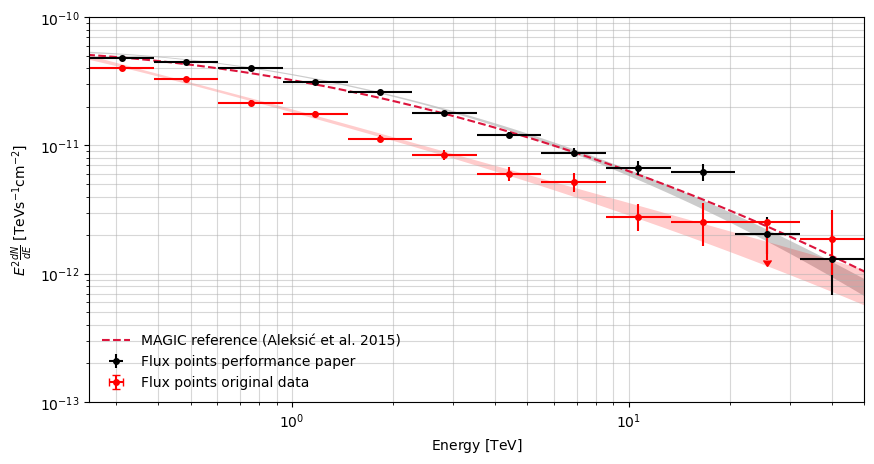

In [41]:
plot_kwargs = {
    "energy_bounds": [0.08, 100] * u.TeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "xunits": u.TeV,
}
cmap = plotting.create_cmap_from_colors(["w", "w", "cornflowerblue"])

# Crab models
crab_magic_100 = create_crab_spectral_model("magic_lp")



fig, ax = plt.subplots(figsize=(10,5))

best_fit_model_paper.spectral_model.plot_error(
    ax=ax, facecolor="k", alpha=0.2, **plot_kwargs
)
best_fit_model.spectral_model.plot_error(
    ax=ax, facecolor="r", alpha=0.2, **plot_kwargs
)
# best_fit_model_s.spectral_model.plot_error(
#     ax=ax, facecolor="mediumblue", alpha=0.2, **plot_kwargs
# )

crab_magic_100.plot(
    ax=ax, ls="--", lw=1.5, color="crimson", label="MAGIC reference (Aleksić et al. 2015)", **plot_kwargs
)

flux_points_paper.plot(sed_type="e2dnde", color="k", label="Flux points performance paper")
flux_points.plot(sed_type="e2dnde", color="r", label="Flux points original data")
# flux_points_s.plot(sed_type="e2dnde", color="b", label="Flux points scaled data")
# flux_points_s.plot_ts_profiles(sed_type="e2dnde", cmap=cmap)

ax.legend(loc=3, frameon=False)
ax.set_ylim([1e-13, 1e-10])
ax.grid(which="both", alpha=0.5)
ax.set_ylabel("$E^2\\frac{dN}{dE}$ [TeVs${}^{-1}$cm${}^{-2}$]")

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=400)
plt.show()

### Then once we have found the SED model we fix the alpha and beta parameters and let the amplitude as a free parameter

In [19]:
# Create the LC Estimator for each run
lc_maker_1d = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    reoptimize=False, # Re-optimizing other free model parameters (not belonging to the source)
    source="crab", 
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)

# -------------------------------------------------------
model_paper.parameters["alpha"].frozen = True
model_paper.parameters["beta"].frozen  = True
# Assigning the fixed parameters model to each dataset
for data in datasets_paper:
    data.models = model_paper
# -------------------------------------------------------
# -------------------------------------------------------
model.parameters["alpha"].frozen = True
model.parameters["beta"].frozen  = True
# Assigning the fixed parameters model to each dataset
for data in datasets:
    data.models = model
# -------------------------------------------------------
# -------------------------------------------------------
model_s.parameters["alpha"].frozen = True
model_s.parameters["beta"].frozen  = True
# Assigning the fixed parameters model to each dataset
for data in datasets_s:
    data.models = model_s
# -------------------------------------------------------

### Then we run the lightcurve maker run-wise

In [20]:
%%time
print(f"LC will be estimated from {e_lc_min:.1f} to {e_lc_max:.1f}")

# -------------------------------------------------------
lc_runwise_paper = lc_maker_1d.run(datasets_paper)
lightcurve_paper = lc_runwise_paper.to_table(sed_type="flux", format="lightcurve")
# -------------------------------------------------------
# -------------------------------------------------------
lc_runwise = lc_maker_1d.run(datasets)
lightcurve = lc_runwise.to_table(sed_type="flux", format="lightcurve")
# -------------------------------------------------------
# -------------------------------------------------------
lc_runwise_s = lc_maker_1d.run(datasets_s)
lightcurve_s = lc_runwise_s.to_table(sed_type="flux", format="lightcurve")
# -------------------------------------------------------

LC will be estimated from 0.2 TeV to 50.0 TeV
CPU times: user 1min 14s, sys: 2.66 s, total: 1min 17s
Wall time: 1min 17s


### We calculate the mean flux and the statistical error
### Calculating the means, errors, $\chi^2$ and $p$ values

In [21]:
def weighted_average(table, sys_error=0):
    val = table["flux"]
    uncertainty = np.sqrt((sys_error * table["flux"])**2 + table["flux_err"]**2)
    return (val/uncertainty**2).sum() / (1/uncertainty**2).sum(), np.sqrt(1/np.sum(1/uncertainty**2))

def calculate_chi2_pvalue(table, sys_error=0):
    uncertainty = np.sqrt((sys_error * table["flux"])**2 + table["flux_err"]**2)
    flux = table["flux"]
    mean_flux = (flux/uncertainty**2).sum() / (1/uncertainty**2).sum()
    mean_flux_err = np.sqrt(1/np.sum(1/uncertainty**2))
    print(f"Weighted mean flux: {mean_flux:.3e} +/- {mean_flux_err:.3e} cm-2 s-1")
    
    chi2_value = np.sum((table["flux"] - mean_flux)**2/uncertainty**2)
    ndf = len(table["flux"]) - 1
    pvalue = chi2.sf(x=chi2_value, df=ndf)
    print(f"Chi2: {chi2_value:.1f}, ndf: {ndf}, P-value: {pvalue:.2e}")
    return chi2_value, ndf, pvalue

# -------------------------------------------------------
mean_flux_paper, mean_flux_err_paper    = weighted_average(lightcurve_paper)
chi2_val_paper, ndf_paper, pvalue_paper = calculate_chi2_pvalue(lightcurve_paper, sys_error=0.0)
# -------------------------------------------------------
# -------------------------------------------------------
mean_flux,   mean_flux_err   = weighted_average(lightcurve)
chi2_val,   ndf,   pvalue   = calculate_chi2_pvalue(lightcurve, sys_error=0.0)
# -------------------------------------------------------
# -------------------------------------------------------
mean_flux_s, mean_flux_err_s = weighted_average(lightcurve_s)
chi2_val_s, ndf_s, pvalue_s  = calculate_chi2_pvalue(lightcurve_s, sys_error=0.0)
# -------------------------------------------------------

Weighted mean flux: 1.654e-10 +/- 1.139e-12 cm-2 s-1
Chi2: 224.2, ndf: 116, P-value: 6.77e-09
Weighted mean flux: 1.135e-10 +/- 2.188e-12 cm-2 s-1
Chi2: 30.0, ndf: 24, P-value: 1.85e-01
Weighted mean flux: 1.154e-10 +/- 2.218e-12 cm-2 s-1
Chi2: 37.0, ndf: 24, P-value: 4.33e-02


### Extracting the data from the table as arrays

In [22]:
# -------------------------------------------------------
time_min_paper = Time(np.hstack(lightcurve_paper["time_min"]), format='mjd').datetime
time_max_paper = Time(np.hstack(lightcurve_paper["time_max"]), format='mjd').datetime
delta_time_paper  = time_max_paper - time_min_paper
time_center_paper = time_min_paper + delta_time_paper / 2
# Flux and flux error
flux_lst1_paper = np.hstack(lightcurve_paper["flux"])
flux_stat_err_lst1_paper = np.hstack(lightcurve_paper["flux_err"])
# run numbers
run_num_paper = [int(n) for n in observations_paper.ids]
# -------------------------------------------------------
# -------------------------------------------------------
time_min = Time(np.hstack(lightcurve["time_min"]), format='mjd').datetime
time_max = Time(np.hstack(lightcurve["time_max"]), format='mjd').datetime
delta_time  = time_max - time_min
time_center = time_min + delta_time / 2
# Flux and flux error
flux_lst1 = np.hstack(lightcurve["flux"])
flux_stat_err_lst1 = np.hstack(lightcurve["flux_err"])
# run numbers
run_num = [int(n) for n in observations.ids]
# -------------------------------------------------------
# -------------------------------------------------------
time_min_s = Time(np.hstack(lightcurve_s["time_min"]), format='mjd').datetime
time_max_s = Time(np.hstack(lightcurve_s["time_max"]), format='mjd').datetime
delta_time_s  = time_max_s - time_min_s
time_center_s = time_min_s + delta_time_s / 2
# Flux and flux error
flux_lst1_s = np.hstack(lightcurve_s["flux"])
flux_stat_err_lst1_s = np.hstack(lightcurve_s["flux_err"])
# run numbers
run_num_s = [int(n) for n in observations_s.ids]
# -------------------------------------------------------

### The Crab Nebula reference from MAGIC

In [23]:
crab = create_crab_spectral_model("magic_lp")

crab.amplitude.error = 0.03e-11 * u.Unit("cm-2 s-1 TeV-1")
crab.alpha.error = 0.01
crab.beta.error = 0.01/np.log(10)

flux_crab = crab.integral(e_lc_min, e_lc_max)
flux_crab_error = flux_crab * 0

### Plotting the LC

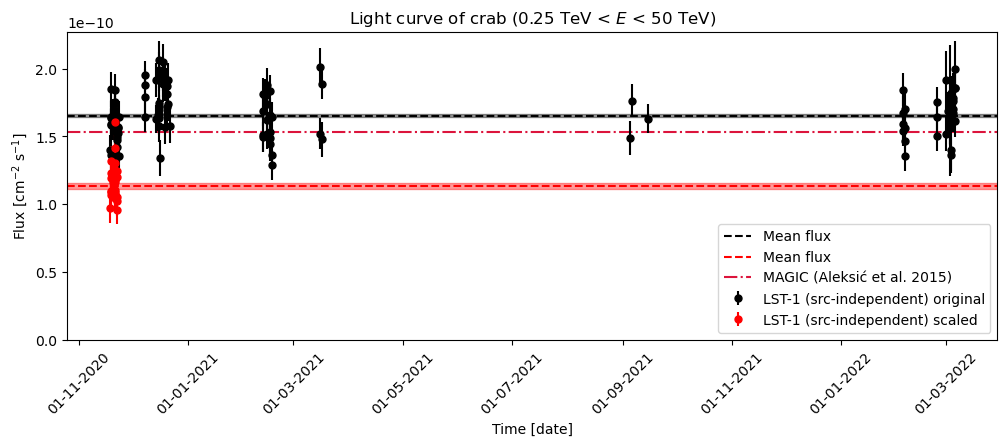

In [42]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plotting the Ligt Curve
ax.errorbar(time_center_paper, flux_lst1_paper, yerr=flux_stat_err_lst1_paper, color="k", ls="", marker=".", ms=10, label="LST-1 (src-independent) original")
ax.errorbar(time_center, flux_lst1_s, yerr=flux_stat_err_lst1_s, color="r", ls="", marker=".", ms=10, label="LST-1 (src-independent) scaled")
# ax.errorbar(time_center_s, flux_lst1_s, yerr=flux_stat_err_lst1_s, color="b", ls="", marker=".", ms=10, label="LST-1 (src-independent) scaled")
    
# Mean flux + error
ax.axhline(mean_flux_paper, ls="--", color="k", zorder=-1, label="Mean flux")
ax.axhspan(mean_flux_paper - mean_flux_err_paper, mean_flux_paper + mean_flux_err_paper, color="k", alpha=0.4, zorder=-1)
ax.axhline(mean_flux, ls="--", color="r", zorder=-1, label="Mean flux")
ax.axhspan(mean_flux - mean_flux_err, mean_flux + mean_flux_err, color="r", alpha=0.4, zorder=-1)
# ax.axhline(mean_flux_s, ls="--", color="b", zorder=-1, label="Mean flux")
# ax.axhspan(mean_flux_s - mean_flux_err_s, mean_flux_s + mean_flux_err_s, color="b", alpha=0.4, zorder=-1)

# MAGIC reference
ax.axhline(flux_crab.value, ls="-.", color="crimson", zorder=-1, label="MAGIC (Aleksić et al. 2015)")

energy_range = f"{e_lc_min:.2f} < $E$ < {e_lc_max:.0f}"
ax.set_title(f"Light curve of {target_name} ({energy_range})")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Time [date]")
# ax.grid()
ax.legend(loc=4)
# ax.set_xlim(18876, 18882.5)
ax.xaxis.set_major_locator(MonthLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%Y"))
plt.xticks(rotation=45)
ax.set_ylim(0)

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

### Plotting the LC run-wise

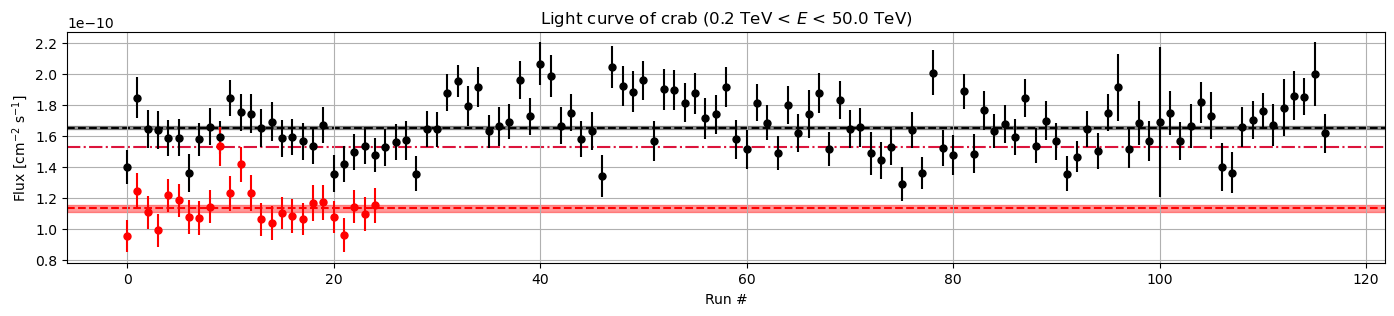

In [44]:
fig, ax = plt.subplots(figsize=(17,3))

# Plotting the Ligt Curve
ax.errorbar(np.arange(len(flux_lst1_paper)), flux_lst1_paper, yerr=flux_stat_err_lst1_paper, color="k", ls="", marker=".", ms=10, label="LST-1 (src-independent)")  
ax.errorbar(np.arange(len(flux_lst1)), flux_lst1, yerr=flux_stat_err_lst1, color="r", ls="", marker=".", ms=10, label="LST-1 (src-independent)")  
# ax.errorbar(np.arange(len(flux_lst1_s)), flux_lst1_s, yerr=flux_stat_err_lst1_s, color="b", ls="", marker=".", ms=10, label="LST-1 (src-independent)")  

# Mean flux + error
ax.axhline(mean_flux_paper, ls="--", color="k", zorder=-1, label="Mean flux")
ax.axhspan(mean_flux_paper - mean_flux_err_paper, mean_flux_paper + mean_flux_err_paper, color="k", alpha=0.4, zorder=-1)
ax.axhline(mean_flux, ls="--", color="r", zorder=-1, label="Mean flux")
ax.axhspan(mean_flux - mean_flux_err, mean_flux + mean_flux_err, color="r", alpha=0.4, zorder=-1)
# ax.axhline(mean_flux_s, ls="--", color="b", zorder=-1, label="Mean flux")
# ax.axhspan(mean_flux_s - mean_flux_err_s, mean_flux_s + mean_flux_err_s, color="b", alpha=0.4, zorder=-1)
# MAGIC reference
ax.axhline(flux_crab.value, ls="-.", color="crimson", zorder=-1, label="MAGIC (Aleksić et al. 2015)")

# ax.legend()
ax.grid()
ax.set_xlabel(f"Run #")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
energy_range = f"{e_lc_min:.1f} < $E$ < {e_lc_max:.1f}"
ax.set_title(f"Light curve of {target_name} ({energy_range})")
plt.show()

### Now we put all inside a dict and we store it in a file

In [ ]:
dict_total = {
    
    "dict_model" : best_fit_model.to_dict(), # SkyModel.from_dict(<>)
    
    "table_sed"  : flux_points.to_table(),   # FluxPoints.from_table(<>)

    "lightcurve" : {

        "run_number" : run_num,
        "t_start"    : time_min,
        "t_stop"     : time_max,
        "timedelta"  : delta_time,
        "flux"       : flux_lst1,
        "e_flux"     : flux_stat_err_lst1,
        
        "global" : {
            "e_min"               : e_lc_min,
            "e_max"               : e_lc_max,
            "n_off_regions"       : n_off_regions,
            "target_name"         : target_name,
            "crab_reference_flux" : flux_crab,
            "chi2"                : chi2_val,
            "pvalue"              : pvalue
        }
    }
}


# Saving the object
# with open(fname_dict, 'wb') as f:
#     pickle.dump(dict_total, f, pickle.HIGHEST_PROTOCOL)